# Methods for Recognition and Classification of Human Behaviour Through Sensor-Driven Insights

### _Mark Turos  - March 2024 - Coventry University_
### _Student ID: 9238806_

#### Import all required libraries

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#### Initial data preprocessing. More specifically data aggregation and feature generation + assignment.

In [3]:
#feature generation
def generate_feature_names():
    prefixes = ['T', 'RA', 'LA', 'RL', 'LL']
    suffixes = ['acc', 'gyro', 'mag']
    axes = ['x', 'y', 'z']
    
    feature_names = []
    for prefix in prefixes:
        for suffix in suffixes:
            for axis in axes:
                feature_names.append(f"{prefix}_{axis}{suffix}")
    return feature_names

In [4]:
#open -> read data -> aggregate into a pandas DataFrame
def aggregate_data(root_dir):
    aggregated_data = []
    for activity_dir in os.listdir(root_dir):
        activity_path = os.path.join(root_dir, activity_dir)
        if os.path.isdir(activity_path):
            for person_dir in os.listdir(activity_path):
                person_path = os.path.join(activity_path, person_dir)
                if os.path.isdir(person_path):
                    for sequence_file in os.listdir(person_path):
                        sequence_path = os.path.join(person_path, sequence_file)
                        with open(sequence_path, 'r') as f:
                            for line in f:
                                row = line.strip().split(',')
                                aggregated_data.append([activity_dir, person_dir, sequence_file.split('.')[0]] + row)

    feature_names = generate_feature_names()
    # adjusted columns to include metadata features
    column_names = ['Activity', 'Person', 'Sequence'] + feature_names
    df = pd.DataFrame(aggregated_data, columns=column_names)
    return df

In [5]:
#use aggregate_data function on actual dataset
root_dir = './data'  # edit with your own data path for self-use
df = aggregate_data(root_dir)
print(df.head())

  Activity Person Sequence  T_xacc  T_yacc  T_zacc    T_xgyro   T_ygyro  \
0      a01     p1      s01  8.1305  1.0349  5.4217  -0.009461  0.001915   
1      a01     p1      s01  8.1305  1.0202  5.3843  -0.009368  0.023485   
2      a01     p1      s01  8.1604  1.0201  5.3622   0.015046   0.01433   
3      a01     p1      s01  8.1603  1.0052   5.377   0.006892  0.018045   
4      a01     p1      s01  8.1605  1.0275  5.3473   0.008811  0.030433   

     T_zgyro    T_xmag  ...    RL_zmag  LL_xacc  LL_yacc LL_zacc   LL_xgyro  \
0  -0.003424  -0.78712  ...  -0.036453  -2.8071  -9.0812   2.622  -0.000232   
1   0.001953  -0.78717  ...  -0.034005  -2.8146  -9.0737  2.6218  -0.014784   
2   0.000204  -0.78664  ...  -0.036489  -2.8221  -9.0886  2.6366   -0.01277   
3   0.005649  -0.78529  ...  -0.036151  -2.8071  -9.0811   2.607  -0.005725   
4  -0.005346  -0.78742  ...  -0.033807  -2.8146  -9.0737  2.6218  -0.003929   

    LL_ygyro   LL_zgyro  LL_xmag  LL_ymag    LL_zmag  
0  -0.012092  -0.00

In [5]:
# export df to a text file
df.to_csv('aggregated_data.txt', sep='\t', index=False)

#export df to a .csv file
#df.to_csv('aggregated_data.csv', sep='\t', index=False)

#### Pivoting the data for PCA

In [6]:
df['step'] = df.groupby(['Activity', 'Person', 'Sequence']).cumcount() + 1

# list for rows of the new DataFrame
rows_list = []

for (activity, person, sequence), group in df.groupby(['Activity', 'Person', 'Sequence']):
    # dictionary for each group's new row
    new_row = {'Activity': activity, 'Person': person, 'Sequence': sequence}
    
    for _, row in group.iterrows():
        step = row['step']
        for col in df.columns[3:-1]:  # exclude control columns and 'step'
            new_col_name = f"{col}_{step}"
            new_row[new_col_name] = row[col]

    rows_list.append(new_row)

reshaped_df = pd.DataFrame(rows_list)

In [7]:
reshaped_df.to_csv('reshaped_data.txt', sep='\t', index=False)

#### Standardizing the Data

In [7]:
# identify the columns to be standardized
columns_to_scale = [col for col in reshaped_df.columns if col not in ['Activity', 'Person', 'Sequence']]

# initialize the StandardScaler
scaler = StandardScaler()

# fit and transform the data - standardize
reshaped_df[columns_to_scale] = scaler.fit_transform(reshaped_df[columns_to_scale])

In [9]:
reshaped_df.to_csv('reshaped_stand.txt', sep='\t', index=False)
reshaped_df.head()

,Activity,Person,Sequence,T_xacc_1,T_yacc_1,T_zacc_1,T_xgyro_1,T_ygyro_1,T_zgyro_1,T_xmag_1,...,RL_zmag_125,LL_xacc_125,LL_yacc_125,LL_zacc_125,LL_xgyro_125,LL_ygyro_125,LL_zgyro_125,LL_xmag_125,LL_ymag_125,LL_zmag_125
0,a01,p1,s01,0.043910,0.694400,0.708681,-0.005537,-0.029848,-0.002901,-0.525509,...,-0.288563,0.722710,-0.975737,0.929428,0.009954,-0.073777,-0.012869,0.765033,0.017691,-0.341628
1,a01,p1,s02,0.015169,0.744721,0.777895,-0.000824,0.006613,-0.019674,-0.535426,...,-0.293285,0.721381,-0.978341,0.938666,0.006658,-0.073450,-0.008069,0.768403,0.015520,-0.344169
2,a01,p1,s03,0.002060,0.733639,0.784031,0.024328,0.009124,-0.019824,-0.548715,...,-0.297774,0.723770,-0.979817,0.937422,0.013624,-0.065174,-0.000077,0.769570,0.013140,-0.344584
3,a01,p1,s04,0.009929,0.739143,0.765977,0.010510,0.010931,0.034610,-0.541943,...,-0.300489,0.711102,-0.979866,0.937511,0.002247,-0.065485,-0.007953,0.771592,0.018475,-0.340151
4,a01,p1,s05,0.001990,0.755577,0.841354,-0.049589,-0.130715,-0.005328,-0.550443,...,-0.295944,0.721112,-0.983747,0.938222,0.030071,-0.030425,0.002422,0.767885,0.018972,-0.339596


#### PCA

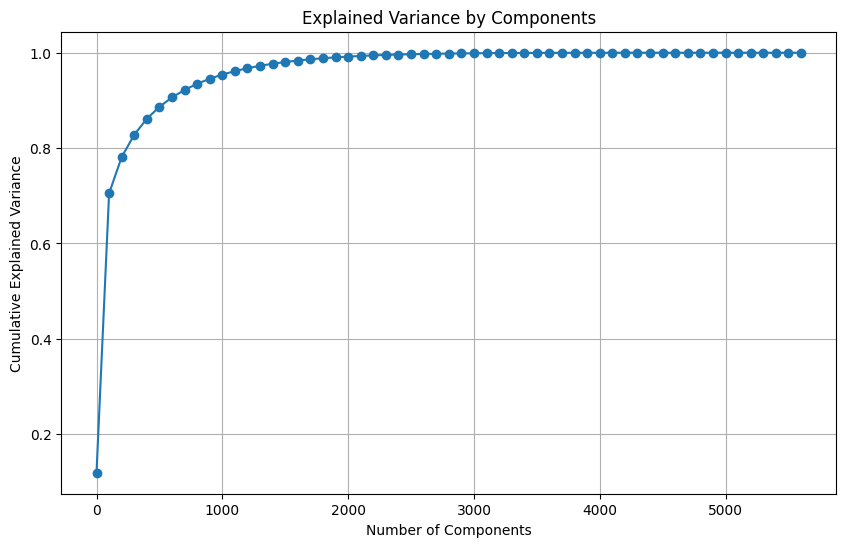

In [8]:

# feature extraction to apply PCA on
features = reshaped_df.drop(['Activity', 'Person', 'Sequence'], axis=1)
features_names = features.columns

# init PCA with enough components to compute explained variance
pca = PCA(n_components=min(len(features_names), features.shape[0]))
pca_features = pca.fit_transform(features)

# cumulative variance explained to decide on number of components for plot
variance_explained_cumulative = pca.explained_variance_ratio_.cumsum()
sample_rate = 100
# plotting the cumulative variance 
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(variance_explained_cumulative), sample_rate), variance_explained_cumulative[::sample_rate], marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

Number of components to explain 90% of variance: 567


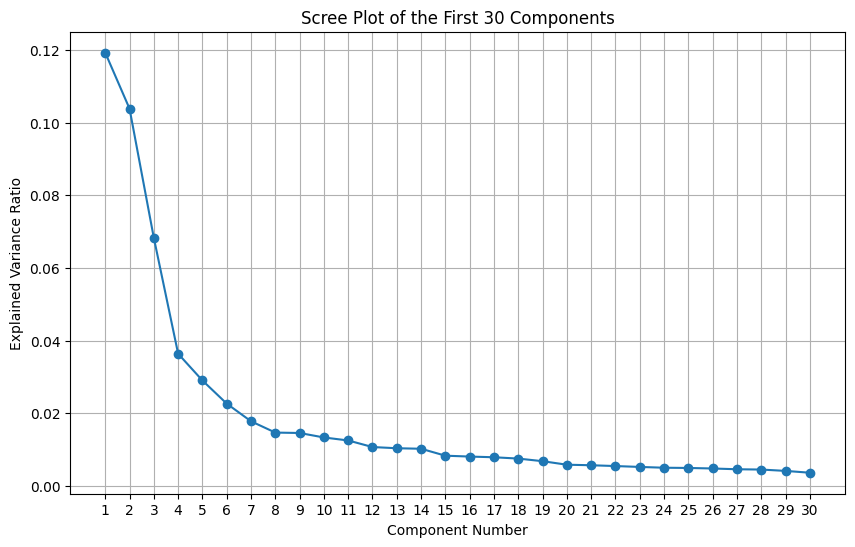

In [9]:
# choosing the number of components to capture 90% of the variance
n_components_90 = (variance_explained_cumulative < 0.90).sum() + 1

print(f"Number of components to explain 90% of variance: {n_components_90}")

# re-apply PCA with the chosen number of components
pca_optimal = PCA(n_components=n_components_90)
pca_features_optimal = pca_optimal.fit_transform(features)

# pca_features_optimal now contains the dataset reduced to the number of components
# that explain 90% of the variance.


# Scree plot of first 30 components
n_display_components = 30

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_display_components + 1), pca.explained_variance_ratio_[:n_display_components], 'o-')
plt.xticks(np.arange(1, n_display_components + 1, step=1))  # components labelling
plt.title('Scree Plot of the First {} Components'.format(n_display_components))
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()



In [10]:
pca_df = pd.DataFrame(pca_features_optimal, columns=[f'PC{i+1}' for i in range(pca_features_optimal.shape[1])])
pca_df.insert(0, 'Activity', reshaped_df['Activity'].values)
pca_df.head()

,Activity,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC558,PC559,PC560,PC561,PC562,PC563,PC564,PC565,PC566,PC567
0,a01,-1.637071,-0.838735,3.347988,-9.458428,-7.743542,-23.807102,-9.581168,-7.642276,-11.361544,...,-0.015749,0.114796,-0.094188,0.007550,-0.023733,-0.038515,0.018733,0.024024,-0.036693,0.026891
1,a01,-1.749408,-0.970375,3.377247,-9.282271,-7.725263,-23.857871,-9.762795,-7.540563,-11.318304,...,-0.012978,0.082819,-0.106038,0.079903,-0.033059,-0.035660,0.052520,0.047151,0.004830,0.019190
2,a01,-1.748035,-1.016446,3.374029,-9.110532,-7.734951,-23.876501,-9.873329,-7.561801,-11.326529,...,-0.009543,0.075785,-0.102441,0.080893,-0.018141,-0.041872,0.032829,0.047316,-0.014959,0.032264
3,a01,-1.700473,-1.116532,3.374351,-9.011856,-7.627430,-23.929857,-9.868561,-7.549670,-11.321522,...,0.007098,0.034036,-0.068624,0.052352,-0.034342,-0.053343,0.065111,0.045652,-0.003976,0.021196
4,a01,-1.590936,-1.198873,3.333404,-8.908969,-7.557410,-23.990856,-9.868686,-7.565691,-11.325636,...,-0.017862,0.060835,-0.110645,0.039713,-0.010425,-0.049608,0.019926,0.033930,-0.017802,0.026427


In [13]:
pca_df.to_csv('pca_data.txt', sep='\t', index=False)

In [11]:
# init the encoder
le = LabelEncoder()

# encode 'acitvity
pca_df['ActivityEncoded'] = le.fit_transform(pca_df['Activity'])
pca_df.head(1000)

,Activity,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC559,PC560,PC561,PC562,PC563,PC564,PC565,PC566,PC567,ActivityEncoded
0,a01,-1.637071,-0.838735,3.347988,-9.458428,-7.743542,-23.807102,-9.581168,-7.642276,-11.361544,...,0.114796,-0.094188,0.007550,-0.023733,-0.038515,0.018733,0.024024,-0.036693,0.026891,0
1,a01,-1.749408,-0.970375,3.377247,-9.282271,-7.725263,-23.857871,-9.762795,-7.540563,-11.318304,...,0.082819,-0.106038,0.079903,-0.033059,-0.035660,0.052520,0.047151,0.004830,0.019190,0
2,a01,-1.748035,-1.016446,3.374029,-9.110532,-7.734951,-23.876501,-9.873329,-7.561801,-11.326529,...,0.075785,-0.102441,0.080893,-0.018141,-0.041872,0.032829,0.047316,-0.014959,0.032264,0
3,a01,-1.700473,-1.116532,3.374351,-9.011856,-7.627430,-23.929857,-9.868561,-7.549670,-11.321522,...,0.034036,-0.068624,0.052352,-0.034342,-0.053343,0.065111,0.045652,-0.003976,0.021196,0
4,a01,-1.590936,-1.198873,3.333404,-8.908969,-7.557410,-23.990856,-9.868686,-7.565691,-11.325636,...,0.060835,-0.110645,0.039713,-0.010425,-0.049608,0.019926,0.033930,-0.017802,0.026427,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,a03,43.227577,34.477824,-12.095534,-8.375200,20.361622,-27.771605,6.987788,-4.713706,-4.998768,...,-0.030635,-0.021308,0.022873,-0.017032,0.008828,-0.016258,-0.019629,-0.028117,-0.037431,2
996,a03,43.262306,34.375611,-11.937059,-8.318958,20.345167,-27.740823,6.969281,-4.698287,-4.990308,...,-0.046599,-0.016827,0.021276,-0.005034,0.018419,-0.001361,-0.040842,-0.017996,-0.051222,2
997,a03,43.252755,34.461803,-11.932959,-8.250664,20.251832,-27.760514,6.932123,-4.713601,-5.022827,...,-0.019201,-0.030706,0.009574,-0.008496,0.026910,-0.029683,-0.028990,-0.010725,-0.028763,2
998,a03,43.190769,34.484675,-12.030220,-8.171556,20.175666,-27.821783,6.952874,-4.751877,-5.045309,...,-0.062367,-0.022661,-0.009092,-0.011723,0.012385,-0.044613,-0.029110,-0.009162,-0.036343,2


#### Logistic regression

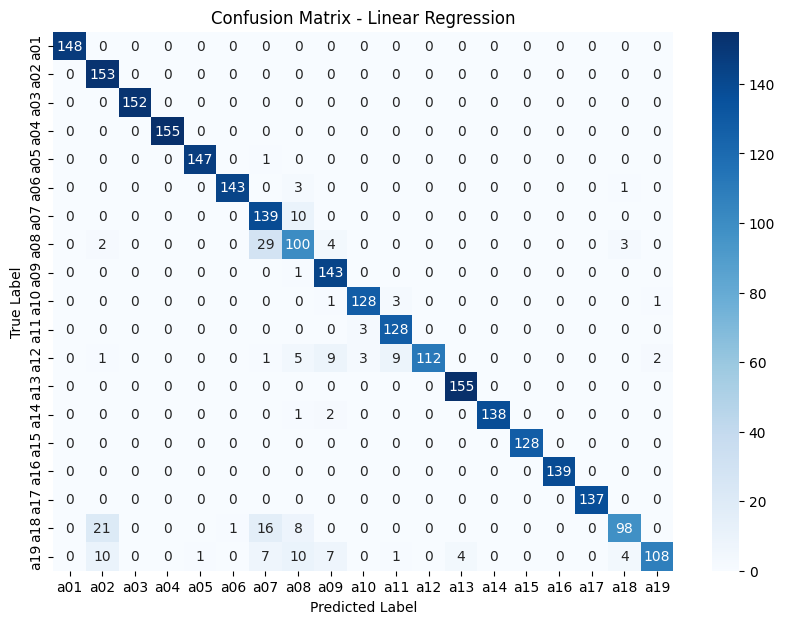

              precision    recall  f1-score   support

         a01       1.00      1.00      1.00       148
         a02       0.82      1.00      0.90       153
         a03       1.00      1.00      1.00       152
         a04       1.00      1.00      1.00       155
         a05       0.99      0.99      0.99       148
         a06       0.99      0.97      0.98       147
         a07       0.72      0.93      0.81       149
         a08       0.72      0.72      0.72       138
         a09       0.86      0.99      0.92       144
         a10       0.96      0.96      0.96       133
         a11       0.91      0.98      0.94       131
         a12       1.00      0.79      0.88       142
         a13       0.97      1.00      0.99       155
         a14       1.00      0.98      0.99       141
         a15       1.00      1.00      1.00       128
         a16       1.00      1.00      1.00       139
         a17       1.00      1.00      1.00       137
         a18       0.92    

In [15]:
def linRegModel():
    # features
    X = pca_df.drop(['Activity', 'ActivityEncoded'], axis=1)
    # target
    y = pca_df['ActivityEncoded']

    # splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

    # init the model
    model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed for convergence

    # train the model
    model.fit(X_train, y_train)

    # predictions
    y_pred = model.predict(X_test)

    # accuracy
    # print("Accuracy:", accuracy_score(y_test, y_pred))

    # confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)

    # heatmap plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix - Linear Regression')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    #classification report
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
linRegModel()


#### Decision Tree

Depth of the tree: 21
Number of leaf nodes: 274


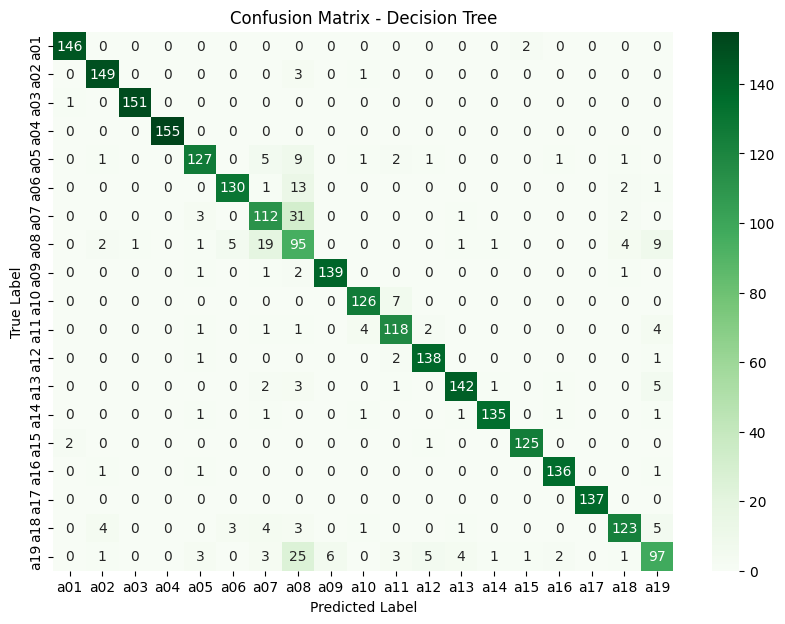

              precision    recall  f1-score   support

         a01       0.98      0.99      0.98       148
         a02       0.94      0.97      0.96       153
         a03       0.99      0.99      0.99       152
         a04       1.00      1.00      1.00       155
         a05       0.91      0.86      0.89       148
         a06       0.94      0.88      0.91       147
         a07       0.75      0.75      0.75       149
         a08       0.51      0.69      0.59       138
         a09       0.96      0.97      0.96       144
         a10       0.94      0.95      0.94       133
         a11       0.89      0.90      0.89       131
         a12       0.94      0.97      0.96       142
         a13       0.95      0.92      0.93       155
         a14       0.98      0.96      0.97       141
         a15       0.98      0.98      0.98       128
         a16       0.96      0.98      0.97       139
         a17       1.00      1.00      1.00       137
         a18       0.92    

In [13]:
def decTreeModel():
    # features
    X = pca_df.drop(['Activity', 'ActivityEncoded'], axis=1)
    # target
    y = pca_df['ActivityEncoded']

    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

    # init the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=69)

    # train the classifier
    clf.fit(X_train, y_train)

    # make predictions
    y_pred = clf.predict(X_test)

    # accuracy
    #print("Accuracy:", accuracy_score(y_test, y_pred))

    # depth of the decision tree
    tree_depth = clf.get_depth()
    print(f"Depth of the tree: {tree_depth}")

    # number of leaf nodes
    num_leaves = clf.get_n_leaves()
    print(f"Number of leaf nodes: {num_leaves}")

    # confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    
    # heatmap plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix - Decision Tree')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    #classification report
    print(classification_report(y_test, y_pred, target_names=le.classes_))

decTreeModel()

#### Gaussian Naive Bayes

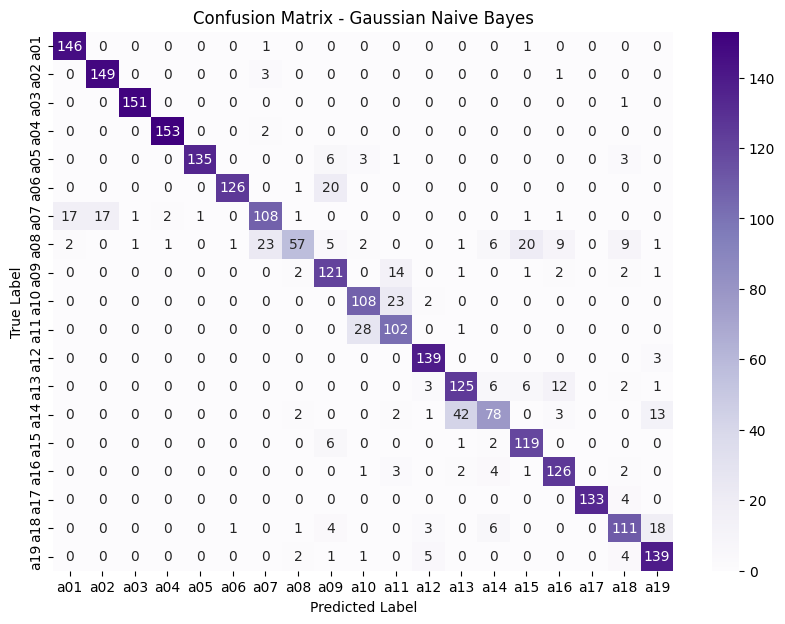

              precision    recall  f1-score   support

         a01       0.88      0.99      0.93       148
         a02       0.90      0.97      0.93       153
         a03       0.99      0.99      0.99       152
         a04       0.98      0.99      0.98       155
         a05       0.99      0.91      0.95       148
         a06       0.98      0.86      0.92       147
         a07       0.79      0.72      0.76       149
         a08       0.86      0.41      0.56       138
         a09       0.74      0.84      0.79       144
         a10       0.76      0.81      0.78       133
         a11       0.70      0.78      0.74       131
         a12       0.91      0.98      0.94       142
         a13       0.72      0.81      0.76       155
         a14       0.76      0.55      0.64       141
         a15       0.80      0.93      0.86       128
         a16       0.82      0.91      0.86       139
         a17       1.00      0.97      0.99       137
         a18       0.80    

In [14]:
def gaussianNBModel():
    # features
    X = pca_df.drop(['Activity', 'ActivityEncoded'], axis=1)
    # target
    y = pca_df['ActivityEncoded']
    # splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
    # init the GNB classifier
    gnb = GaussianNB()

    # train the classifier
    gnb.fit(X_train, y_train)

    # predictions
    y_pred = gnb.predict(X_test)

    # eval the classifier
    # accuracy = accuracy_score(y_test, y_pred)
    # print(f"Accuracy: {accuracy}")

    # confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    
    # heatmap plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Purples', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix - Gaussian Naive Bayes')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


    #classification report
    print(classification_report(y_test, y_pred, target_names=le.classes_))

gaussianNBModel()

    
    

#### SVM ( Linear Classifier )

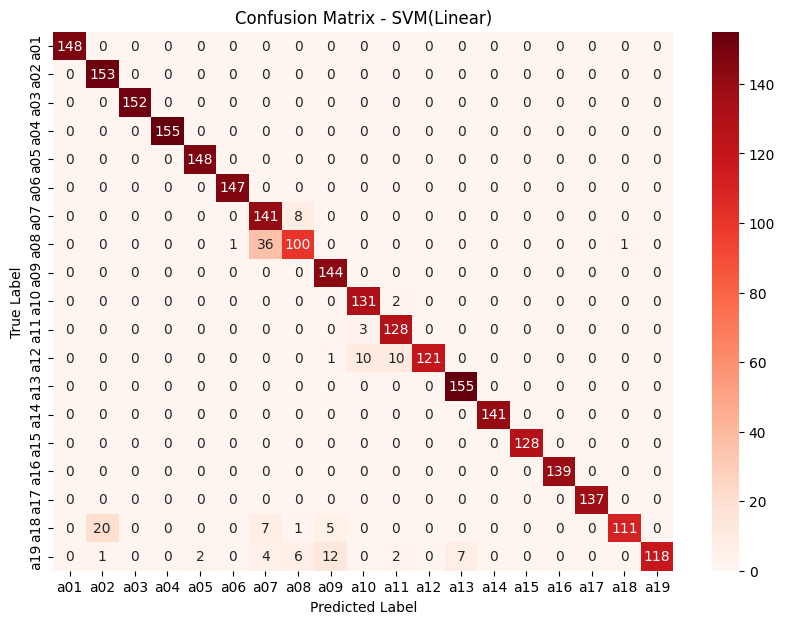

              precision    recall  f1-score   support

         a01       1.00      1.00      1.00       148
         a02       0.88      1.00      0.94       153
         a03       1.00      1.00      1.00       152
         a04       1.00      1.00      1.00       155
         a05       0.99      1.00      0.99       148
         a06       0.99      1.00      1.00       147
         a07       0.75      0.95      0.84       149
         a08       0.87      0.72      0.79       138
         a09       0.89      1.00      0.94       144
         a10       0.91      0.98      0.95       133
         a11       0.90      0.98      0.94       131
         a12       1.00      0.85      0.92       142
         a13       0.96      1.00      0.98       155
         a14       1.00      1.00      1.00       141
         a15       1.00      1.00      1.00       128
         a16       1.00      1.00      1.00       139
         a17       1.00      1.00      1.00       137
         a18       0.99    

In [29]:
def SVM():
    # features
    X = pca_df.drop(['Activity', 'ActivityEncoded'], axis=1)
    # target
    y = pca_df['ActivityEncoded']
    # splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
    
    # init the SV classifier
    svc = SVC(kernel='linear', random_state=69)

    # train the classifier
    svc.fit(X_train, y_train)

    # predictions
    y_pred = svc.predict(X_test)

    # eval the classifier
    # accuracy = accuracy_score(y_test, y_pred)
    # print(f"Accuracy: {accuracy}")

    # confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    
    # heatmap plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix - SVM(Linear)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


    #classification report
    print(classification_report(y_test, y_pred, target_names=le.classes_))

SVM()

    